In [1]:
#TODO: add text and explanation to this notebook

In [2]:
import IPython
import io
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm 
import torchaudio
import torch
from PIL import Image
import numpy as np

import os,sys,inspect
sys.path.insert(0, "..")

from src.data import librispeech
from src.dataprocessing import transforms as T
from src.dataprocessing import audio_normalizing as N
from src.utils import hparams
from src.utils import tierutil

pre_path = '../../'

In [3]:
path = "MelNet-SpeechGeneration/models/params/librispeech/dummymodel_librispeech.yml"
hp = hparams.HParams.from_yaml(pre_path+path)

# I do not want to do the calculations on the GPU
hp["training"]["device"] = torch.device('cpu')

In [4]:
dataset_librispeech = librispeech.download_data(root='../'+hp.data.path, url=hp.data.url)
dataloader_librispeech = torch.utils.data.DataLoader(dataset_librispeech)
dataiter = iter(dataloader_librispeech)

In [5]:
waveform1, sample_rate1, utterance1, speaker_id1, chapter_id1, utterance_id1 = dataiter.next()
waveform2, sample_rate2, utterance2, speaker_id2, chapter_id2, utterance_id2 = dataiter.next()

In [6]:
t = torch.Tensor([[[1,3,1,3],
                  [2,3,2,3],
                  [1,3,1,3],
                  [2,3,2,3]],
                  [[1,3,1,3],
                   [2,3,2,3],
                   [1,3,1,3],
                   [2,3,2,3]]])

In [7]:
t = torch.Tensor([[[1,3,1,3],
                  [2,3,2,3],
                  [1,3,1,3],
                  [2,3,2,3]]])

In [8]:
t12 = t[:, :, ::2]

In [9]:
t3 = t[:, :, 1::2]

In [10]:
t1 = t12[:,::2,:]

In [11]:
t2 = t12[:,1::2,:]

In [12]:
t1, t2, t12, t3, t

(tensor([[[1., 1.],
          [1., 1.]]]),
 tensor([[[2., 2.],
          [2., 2.]]]),
 tensor([[[1., 1.],
          [2., 2.],
          [1., 1.],
          [2., 2.]]]),
 tensor([[[3., 3.],
          [3., 3.],
          [3., 3.],
          [3., 3.]]]),
 tensor([[[1., 3., 1., 3.],
          [2., 3., 2., 3.],
          [1., 3., 1., 3.],
          [2., 3., 2., 3.]]]))

In [13]:
result1 = tierutil.split(t, 1, 3)
result1

(tensor([[[1., 1.],
          [1., 1.]]]),
 tensor([[[1., 1.],
          [1., 1.]]]))

In [14]:
result2 = tierutil.split(t, 2, 3)
result2

(tensor([[[1., 1.],
          [1., 1.]]]),
 tensor([[[2., 2.],
          [2., 2.]]]))

In [15]:
result3 = tierutil.split(t, 3, 3)
result3

(tensor([[[1., 1.],
          [2., 2.],
          [1., 1.],
          [2., 2.]]]),
 tensor([[[3., 3.],
          [3., 3.],
          [3., 3.],
          [3., 3.]]]))

In [32]:
together = tierutil.interleave(result2[1], result2[0], tier=2)
together

1 2 2
torch.Size([1, 4, 2])


tensor([[[1., 1.],
         [2., 2.],
         [1., 1.],
         [2., 2.]]])

In [33]:
together == result3[0]

tensor([[[True, True],
         [True, True],
         [True, True],
         [True, True]]])

In [17]:
melspectrogram = T.wave_to_melspectrogram(waveform1, hp)

In [18]:
melspectrogram.shape

torch.Size([1, 256, 159])

In [19]:
melspectrogram_tier1 = tierutil.split(melspectrogram, 1, 6)

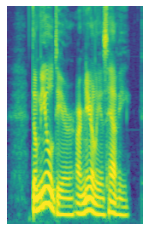

In [20]:
melspectrogram = T.wave_to_melspectrogram(waveform1, hp)
#melspectrogram = T.amplitude_to_db(melspectrogram, hp)
melspectrogram = N.preprocessing(melspectrogram, hp)
T.plot_melspectrogram(melspectrogram, hp)

torch.Size([1, 256, 159])


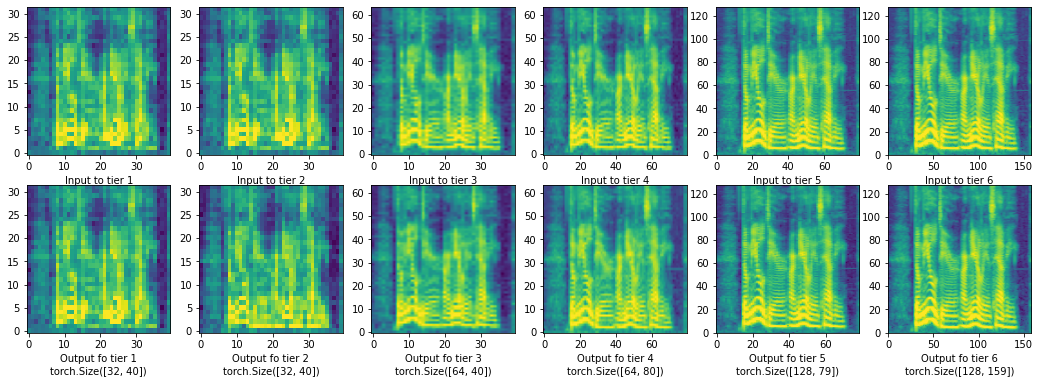

In [21]:
print(melspectrogram.shape)
# In case the spectrogram tensor is in the GPU
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(18, 6))
for i in range(0, 6):
    melspectrogram_tier = tierutil.split(melspectrogram, i+1, 6)
    axes[0][i].imshow(melspectrogram_tier[0][0], origin='lower', aspect="auto")
    #axes[i].axis('off')
    axes[0][i].set_xlabel(f"Input to tier {i+1}\n{melspectrogram_tier[0][0].shape}")
    axes[1][i].imshow(melspectrogram_tier[1][0], origin='lower', aspect="auto")
    #axes[i].axis('off')
    axes[1][i].set_xlabel(f"Output fo tier {i+1}\n{melspectrogram_tier[1][0].shape}")
plt.show()

In [35]:
separated = tierutil.split(melspectrogram, 3, 6)
together = tierutil.interleave(separated[1], separated[0], tier=3)

1 64 40


In [36]:
together.shape

torch.Size([1, 64, 80])

In [37]:
prueba = tierutil.split(melspectrogram, 4, 6)

In [38]:
prueba[0].shape

torch.Size([1, 64, 80])

In [39]:
prueba[0] == together

tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]])